<a href="https://colab.research.google.com/github/jeremiah-toribio/ethy-prophet/blob/main/eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [92]:
# yahoo finance
import yfinance as yf
# personal scripts
import wrangle as w
# prophet model
from prophet import Prophet
# dataframes & matrices
import pandas as pd
import numpy as np
# stats and eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
# viz
import seaborn as sns
import matplotlib.pyplot as plt
# tsa split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
# warnings
import warnings
warnings.filterwarnings("ignore")
# ignore cmdstanpy
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)



In [93]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Acquiring Eth-USD df

In [94]:
eth_usd = yf.Ticker("eth-usd")

In [95]:
pd.DataFrame([eth_usd.info]).T.reset_index()

,index,0
0,twitter,"""https://twitter.com/ethereum"""
1,name,Ethereum
2,startDate,1438905600
3,description,Ethereum (ETH) is a cryptocurrency . Ethereum ...
4,maxAge,86400
5,priceHint,2
6,previousClose,1732.4095
7,open,1732.4095
8,dayLow,1649.636
9,dayHigh,1739.666


In [96]:
eth = eth_usd.history(period='21mo',interval='1h')

In [98]:
eth.to_csv('./eth.csv')
!cp eth.csv "drive/My Drive/"


# Preparing Eth

In [99]:
eth = w.prepare_eth(eth)

# Exploring Eth

<Axes: xlabel='Datetime'>

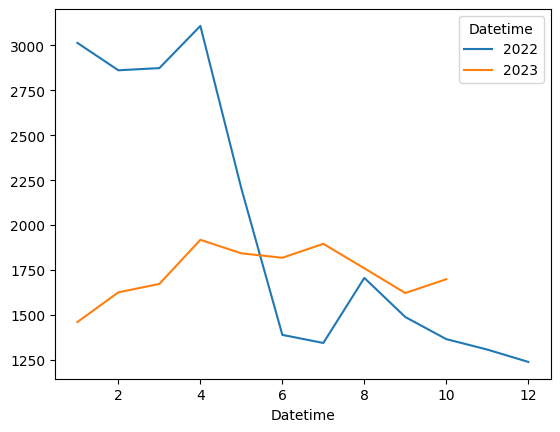

In [101]:
eth.groupby([eth.index.month,eth.index.year])['close'].mean().unstack().plot()

<Axes: xlabel='month'>

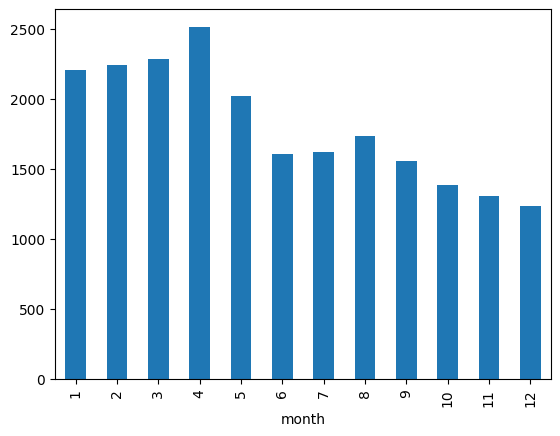

In [182]:
eth.groupby('month')['close'].mean().plot(kind='bar')

<Axes: xlabel='close', ylabel='Count'>

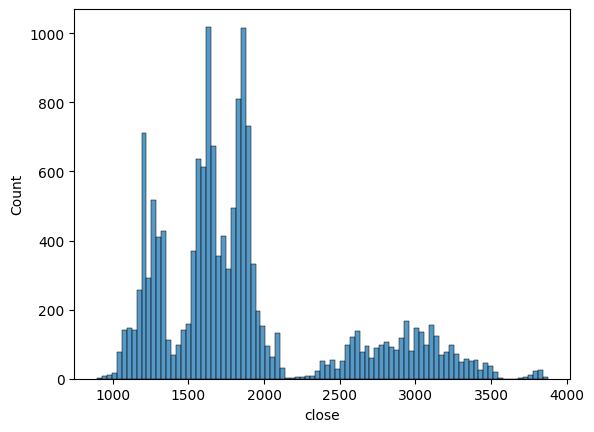

In [191]:
sns.histplot(eth.resample)

<Axes: xlabel='Datetime'>

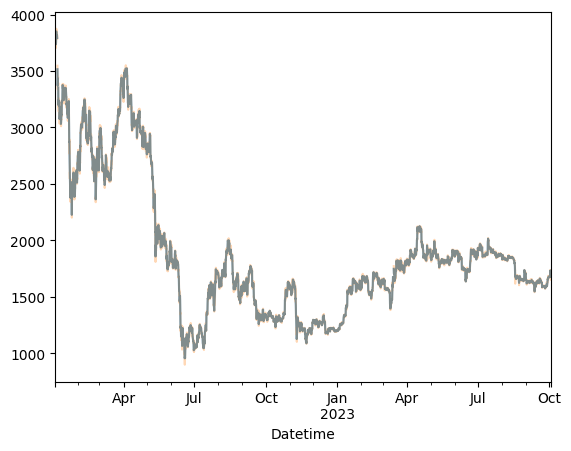

In [184]:
eth.close.resample('4h').mean().plot(alpha=.8)
eth.close.resample('1h').mean().plot(alpha=.3)

# Split

In [103]:
train_size = int(eth.shape[0] * .9)
test_size = int(eth.shape[0] * .1)

test_end_index = train_size + test_size


In [104]:
train = eth.close[:train_size]
test = eth.close[train_size:test_end_index]

In [105]:
print(f'Train shape: {train.shape}, Test shape: {test.shape} , Eth shape: {eth.shape}')

Train shape: (13751,), Test shape: (1527,) , Eth shape: (15279, 9)


In [109]:
# in order to use the prophet model, must rename date as ds and target feature as y
train_model = train.reset_index()
train_model = train_model.rename(columns={'Datetime':'ds', 'close':'y'})
test_model = test.reset_index()
test_model = test_model.rename(columns={'Datetime':'ds', 'close':'y'})

In [110]:
train_model.ds = train_model.ds.astype('datetime64[ns]')
test_model.ds = test_model.ds.astype('datetime64[ns]')
train_model_fit = train_model.copy()

## Split using SKLearn (Did not use)

In [106]:
# dtscv = TimeSeriesSplit(n_splits=3)

In [107]:
# for train_index, test_index in tscv.split(X):

#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Finding Baselines
  - Last Observed Value
  - Simple Average
  - Moving Average

In [187]:
eval_df = pd.DataFrame(columns=['modelName', 'targetVar', 'RMSE'])

In [189]:
# last item in close
last_close = train[-1:][0]

yhat_df = pd.DataFrame(
    {'close': [last_close]},
    index=train.index)

yhat_df.head()

,close
Datetime,
2022-01-02 18:00:00+00:00,1870.625977
2022-01-02 19:00:00+00:00,1870.625977
2022-01-02 20:00:00+00:00,1870.625977
2022-01-02 21:00:00+00:00,1870.625977
2022-01-02 22:00:00+00:00,1870.625977


# Initial Prophet model has been fit on about 19 months of prior data and can now be used to make predictions -- this will be used to predict on about 2 months of most recent data (test)

In [108]:
m = Prophet(yearly_seasonality=False, changepoint_prior_scale=.1)

In [111]:
train_model_fit

,ds,y
0,2022-01-02 18:00:00,3791.002197
1,2022-01-02 19:00:00,3795.633301
2,2022-01-02 20:00:00,3804.458008
3,2022-01-02 21:00:00,3811.528320
4,2022-01-02 22:00:00,3824.622314
...,...,...
13746,2023-07-30 22:00:00,1855.837036
13747,2023-07-30 23:00:00,1861.760620
13748,2023-07-31 00:00:00,1872.931641
13749,2023-07-31 01:00:00,1871.699341


In [112]:
model = m.fit(train_model_fit)

## Forecast DF with predicted values

In [113]:
future = model.make_future_dataframe(periods=40, freq='H')
forecast = model.predict(future)

# Test predicted

In [114]:
testmodel_forecast = model.predict(test_model)

## Exploring Forecast for train and test

In [115]:
forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2022-01-02 18:00:00,3774.887749,-5.660880,0.196866,3769.423734
1,2022-01-02 19:00:00,3772.422243,-5.890071,0.088705,3766.620877
2,2022-01-02 20:00:00,3769.956738,-6.124770,0.144701,3763.976668
3,2022-01-02 21:00:00,3767.491232,-6.362706,0.374436,3761.502962
4,2022-01-02 22:00:00,3765.025726,-6.601409,0.618422,3759.042739
...,...,...,...,...,...
13786,2023-08-01 14:00:00,1849.736537,5.631112,0.652203,1856.019851
13787,2023-08-01 15:00:00,1849.723265,6.329409,0.589029,1856.641703
13788,2023-08-01 16:00:00,1849.709993,7.002104,0.494839,1857.206936
13789,2023-08-01 17:00:00,1849.696722,7.645212,0.360393,1857.702327


In [116]:
testmodel_forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-07-31 03:00:00,1850.201043,-7.709203,-1.141326,1841.350514
1,2023-07-31 04:00:00,1850.187772,-7.892697,-1.006335,1841.288740
2,2023-07-31 05:00:00,1850.174500,-8.056298,-0.686215,1841.431988
3,2023-07-31 06:00:00,1850.161229,-8.196939,-0.439604,1841.524686
4,2023-07-31 07:00:00,1850.147957,-8.311625,-0.381031,1841.455301
...,...,...,...,...,...
1522,2023-10-02 13:00:00,1830.001631,-8.304843,0.647203,1822.343991
1523,2023-10-02 14:00:00,1829.988359,-8.167262,0.652203,1822.473299
1524,2023-10-02 15:00:00,1829.975087,-7.986395,0.589029,1822.577721
1525,2023-10-02 16:00:00,1829.961816,-7.761342,0.494839,1822.695313


<Axes: xlabel='Datetime', ylabel='y'>

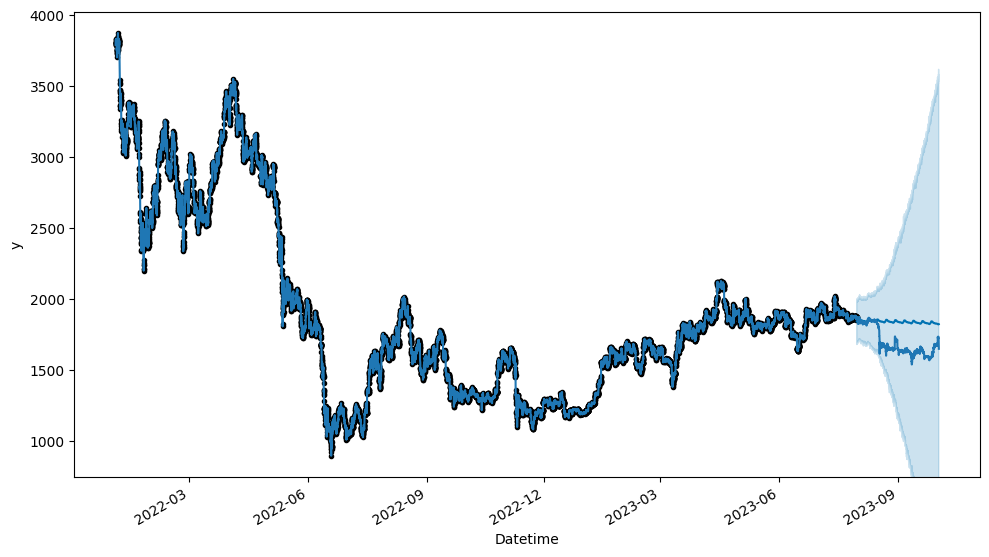

In [164]:
model.plot(testmodel_forecast)
eth.close.plot()

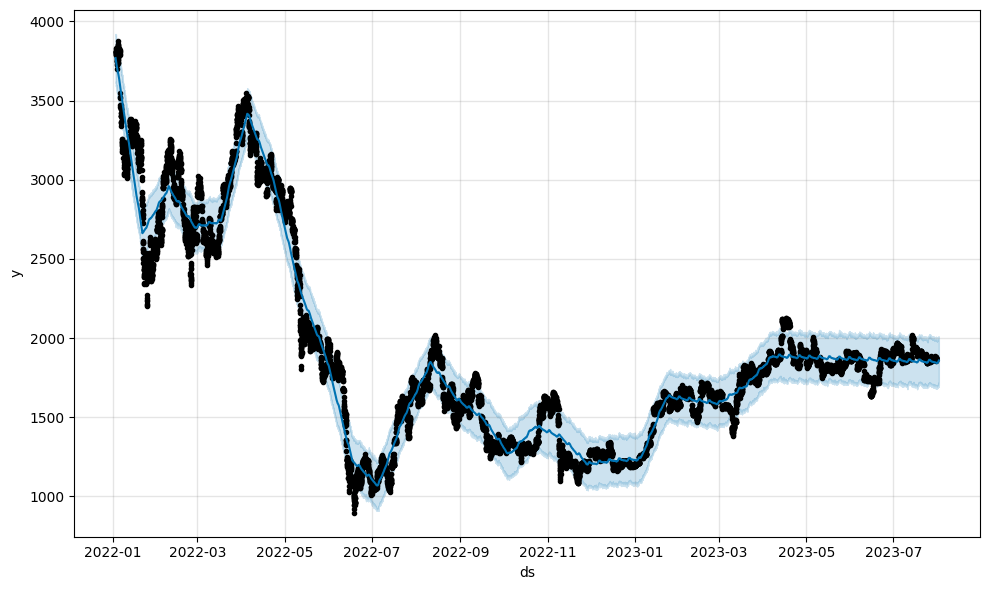

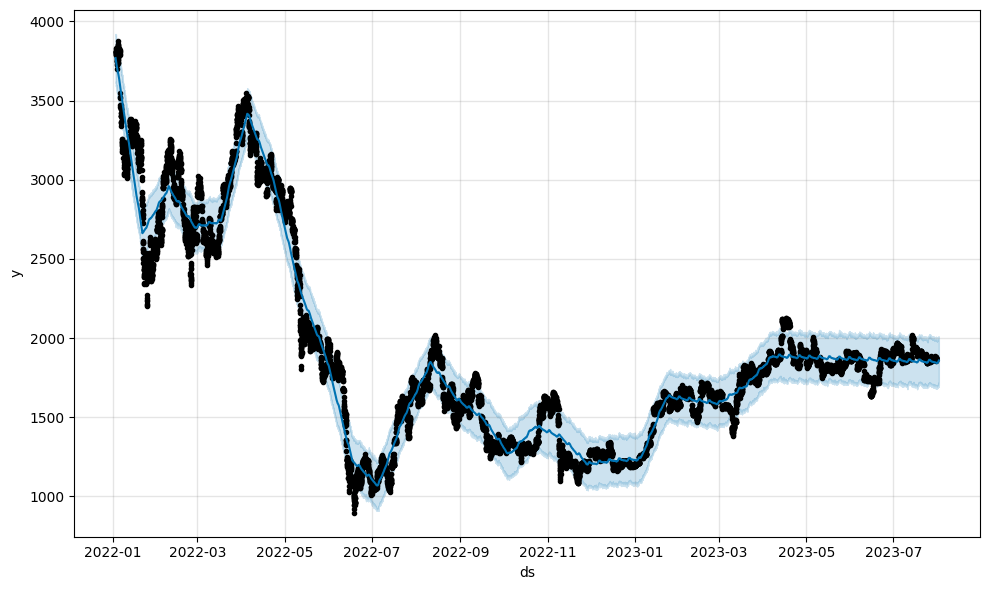

In [118]:
m.plot(forecast)

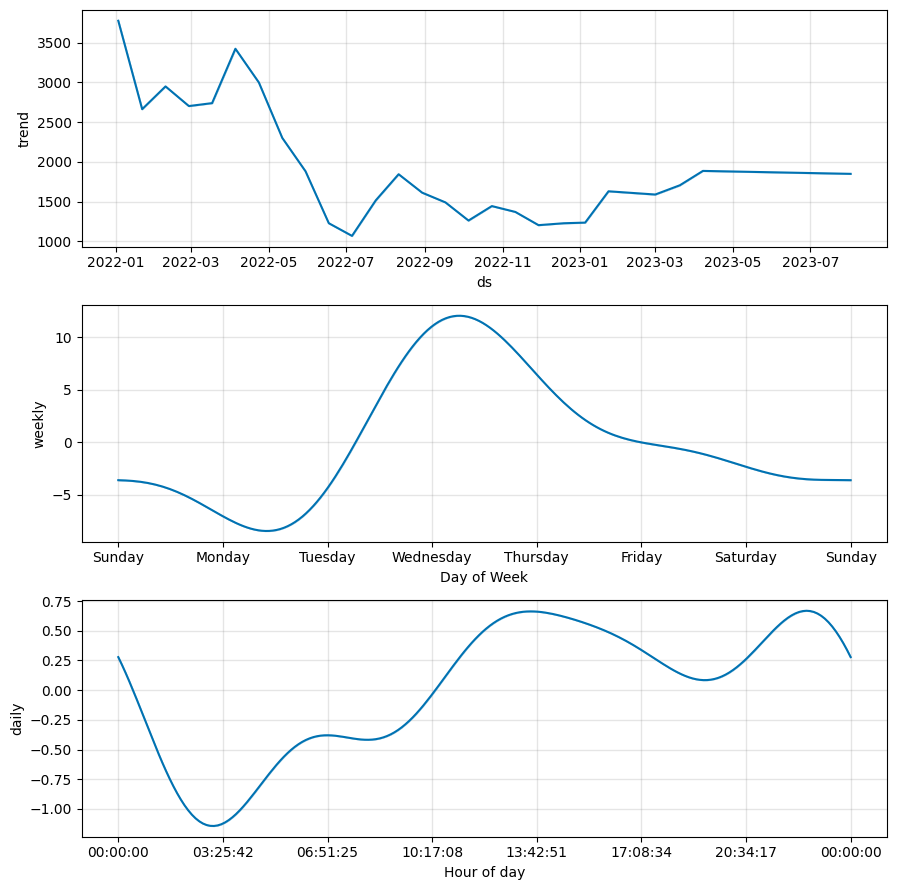

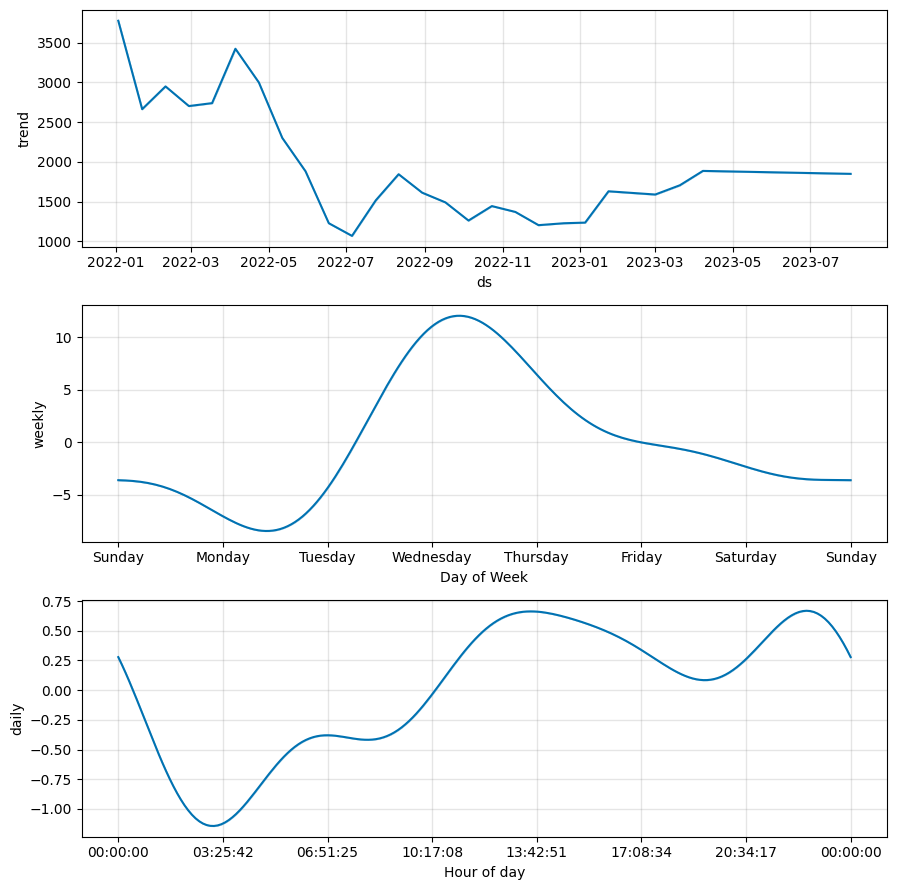

In [119]:
m.plot_components(forecast)

# Parameter Tuning

In [120]:
# importing US holidays for model date identification

import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2023]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [121]:
p_grid = {
          'seasonality_mode':('multiplicative','additive'),
          'holidays_prior_scale':[3,4,5,6,7],
          'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
          'changepoint_range':[0.65,0.70,0.75,0.80,0.85]
          }

grid = ParameterGrid(p_grid)

its = 0
for p in grid:
  its = its+1

print(f'Total number of models: {its}')

Total number of models: 250


In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
i = 0
for x in grid:
    test = pd.DataFrame()
    i += 1
    print(f'Num of Iteration: {i} of {its}')
    print(x)
    np.random.seed(4343)
    train_model_loop =Prophet(changepoint_prior_scale = x['changepoint_prior_scale'],
                         holidays_prior_scale = x['holidays_prior_scale'],
                         seasonality_mode = x['seasonality_mode'],
                         weekly_seasonality= True,
                         daily_seasonality = True,
                         yearly_seasonality= False,
                         holidays=holiday,
                         interval_width=0.95)
    train_model_loop.add_country_holidays(country_name='US')
    train_model_loop.fit(train_model)
    train_forecast = train_model_loop.make_future_dataframe(periods=40, freq='H',include_history = False)
    train_forecast = train_model_loop.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(test_model.y.tail(40),abs(test[['yhat']]))
    print('Mean Absolute Percentage Error(MAPE): +++++++',round(MAPE * 100, 4) )
    model_parameters = model_parameters.append({'MAPE':round(MAPE * 100, 2),'Parameters':x},ignore_index=True)

In [135]:
# saved_params = model_parameters.copy()

In [171]:
pd.set_option('display.max_colwidth', None)
saved_params[saved_params['MAPE'] == 8.30]

,MAPE,Parameters
208,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.65, 'holidays_prior_scale': 7, 'seasonality_mode': 'multiplicative'}"
220,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.75, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
230,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
218,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 7, 'seasonality_mode': 'multiplicative'}"
210,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
200,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
228,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.75, 'holidays_prior_scale': 7, 'seasonality_mode': 'multiplicative'}"
238,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 7, 'seasonality_mode': 'multiplicative'}"
240,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.85, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}"
248,8.3,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.85, 'holidays_prior_scale': 7, 'seasonality_mode': 'multiplicative'}"


In [160]:
saved_params.sort_values('MAPE',ascending=True,inplace=True)

In [170]:
saved_params.Parameters.iloc[208]

{'changepoint_prior_scale': 0.1,
 'changepoint_range': 0.75,
 'holidays_prior_scale': 4,
 'seasonality_mode': 'multiplicative'}

In [163]:
# exporting hyperparams as csv to save data

# saved_params.to_csv('hyperparams.csv')